# Van der Pol System Example for Koopman MPC

## 0. 原空间非线性系统的构造

定义如下有输入的Van der Pol系统：

$$
\left
\{
\begin{aligned}
\dot{x}_{1} &= 2 x_{2} \\
\dot{x}_{2} &= -0.8 x_{1} + 2 x_{2} - 10 x_{1}^{2} x_{2} + u
\end{aligned}
\right.
$$

In [114]:
import numpy as np


def VanderPol(STATE, t, INPUT):
    x1, x2 = STATE
    return [2 * x2, -0.8 * x1 + 2 * x2 - 10 * np.power(x1, 2) * x2 + INPUT]


仿真实例

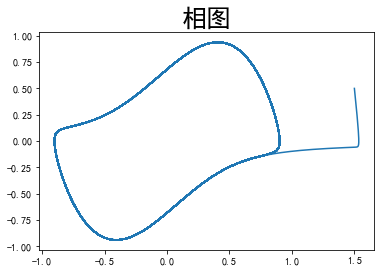

In [115]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt


InitialCondition = [1.5, 0.5]
dt = 0.01
timespan = np.arange(0, 1000 + dt, dt)

Snapshots = odeint(VanderPol, InitialCondition, timespan, args=(0,)).T

# 中文显示问题
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

plt.plot(Snapshots[0, :].T, Snapshots[1, :].T)
plt.title("相图", fontsize=25)
plt.show()


## 1. 从DMDc到高维Koopman控制系统辨识

<!--
 * @Author: CTC 2801320287@qq.com
 * @Date: 2023-02-25 23:17:59
 * @LastEditors: CTC 2801320287@qq.com
 * @LastEditTime: 2023-02-26 17:45:37
 * @Description: 
 * 
 * Copyright (c) 2023 by ${git_name_email}, All Rights Reserved. 
-->

DMD方法只可以用于近似没有输入的系统自身内部的动力学行为。然而，在实际的工程应用中，受控的系统显然更具有普遍性。因此，需要对最基础的DMD算法拓展，使之能应用于有外部输入的系统，即*Dynamic Mode Decomposition with **control***，简称**DMDc**。

**DMDc**的目的是，在离散的系统中，找到如下三个量之间关系的，线性形式的描述：当前可测得的状态量$\vec{x}_k$、未来的状态量$\vec{x}_{k+1}$、当前的输入$\vec{u}_k$。可以通过一堆线性运算算子来提供上述的这种关系：

$$
\vec{x}_{k+1} \approx A \vec{x}_{k} + B \vec{u}_{k}.
$$

其中，$\vec{x}_{j} \in \mathbb{R}^{n}$，$\vec{u}_{j} \in \mathbb{R}^{l}$，$A \in \mathbb{R}^{n \times n}$，$B \in \mathbb{R}^{n \times l}$。线性运算算子$A$和$B$是使得所有数据拟合最好。我们定义一个矩阵，它的列向量是控制输入的快照（snapshot）：

$$
Y = \begin{bmatrix}
    \vec{u}_1&\vec{u}_2&\cdots&\vec{u}_{m-1}
\end{bmatrix}.
$$

可以写出与之前自治系统的DMD算法类似的形式：

$$
X' \approx A X + B Y.
$$

DMDc算法所做的是，利用已知的$X$、$X'$和$Y$，找到使得上式拟合效果最好的$A$和$B$。


将$X' \approx A X + B Y$重新写为如下形式：

$$
X' \approx \begin{bmatrix}
A&B
\end{bmatrix}
\begin{bmatrix}
X \\ Y
\end{bmatrix}
=G \Omega
$$

相当于，我们将状态量和输入的数据合并为一组快照$\Omega$，寻找$G$使得线性映射拟合效果最佳，有：

$$
\begin{aligned}
    G&=X' \Omega^{\dagger}\\
    \begin{bmatrix}
        A&B
    \end{bmatrix}
    &=X' \begin{bmatrix}
        X \\ Y
    \end{bmatrix}^{\dagger}
\end{aligned}
$$

类似地，计算$\Omega$的截断SVD，截断到$p$阶，得到

$$
\Omega_{(n+l) \times m}= \tilde{U}_{(n+l) \times p} \tilde{\Sigma}_{p \times p} (\tilde{V}_{m \times p})^{H},
$$

进而可以得到：

$$
G_{n \times (n+l)} = X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U}_{(n+l) \times p})^{H}.
$$

回到$G$的定义$G \triangleq \begin{bmatrix}
    A & B
\end{bmatrix}$，可得到：

$$
\begin{aligned}
    \begin{bmatrix}
        A_{n \times n} & B_{n \times l}
    \end{bmatrix}
    & =  X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U}_{(n+l) \times p})^{H}\\
    & =
    \begin{bmatrix}
        X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U_1})^{H}_{n \times p} &
        X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U_2})^{H}_{l \times p}
    \end{bmatrix}.
\end{aligned}
$$

类似DMD算法，需要进行降维，以提升运算效率。这里我们先引入**输出数据的SVD**，并截断到$r$阶：

$$
X'_{n \times m} = \hat{U}_{n \times r} \hat{\Sigma}_{r \times r} (\hat{V}_{m \times r})^{H}
$$

需注意，**$r<p$**，即$X^{\prime}$的截断阶数小于$\Omega$的截断阶数。

将动态系统投影到$X'$的POD模态上：

$$
\begin{aligned}
    \vec{x}_{k+1} & = A \vec{x}_{k} + B \vec{u}_{k}\\
    \hat{U}^{H} \vec{x}_{k+1} & = (\hat{U}^{H} A \hat{U}) (\hat{U}^{H} \vec{x}_{k})+ (\hat{U}^{H} B) \vec{u}_{k}\\
    \Rightarrow \vec{\tilde{x}}_{k+1} & = \tilde{A} \vec{\tilde{x}}_{k} + \tilde{B} \vec{u}_{k}.
\end{aligned}
$$

至此，我们得到了$A$和$B$的降维形式：

$$
\begin{aligned}
    \tilde{A}_{r \times r} & = (\hat{U}_{n \times r})^{H} A_{n \times n} \hat{U}_{n \times r} \\
    & = (\hat{U}_{n \times r})^{H} X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U_1})^{H}_{n \times p} \hat{U}_{n \times r},
\end{aligned}
$$

$$
\begin{aligned}
    \tilde{B}_{r \times l} & = (\hat{U}_{n \times r})^{H} B_{n \times l}\\
    & = (\hat{U}_{n \times r})^{H} X'_{n \times m} \tilde{V}_{m \times p} (\tilde{\Sigma}_{p \times p})^{-1} (\tilde{U_2})^{H}_{l \times p}.
\end{aligned}
$$

类似DMD算法，对$\tilde{A}$作谱分解，得到$\tilde{A} W = W \Lambda$。其中$W$的列是$\tilde{A}$的特征向量，$\Lambda$是对角元素为$\tilde{A}$特征值的对角阵。

至此，我们可以得到各阶DMD模态$\vec{\phi}_j$，其形式为：

$$
\vec{\phi}_{j}= X' \tilde{V} \tilde{\Sigma}^{-1} (\tilde{U}_{1})^{H} \hat{U} \vec{w}_{j}.
$$

整个DMD模态矩阵为：

$$
\Phi_{n \times r} = X' \tilde{V} \tilde{\Sigma}^{-1} (\tilde{U}_{1})^{H} \hat{U} W
$$

以上是常见的DMDc流程。简言之，**DMDc**的流程为：

1. 收集数据，构造快照矩阵(*snapshot matrices*)，得到矩阵$X$、$X'$和$Y$，随后将$X$和$Y$接，得到$\Omega$；
2. 计算新的输入$\Omega$的$p$阶截断的SVD，得到$\Omega \approx \tilde{U} \tilde{\Sigma} \tilde{V}^{H}$；
3. 计算输出$X'$的$r$阶截断的SVD（需注意，$r<p$），得到$X' \approx \hat{U} \hat{\Sigma} \hat{V}^{H}$；
4. 根据

   $$
   \tilde{A} = \hat{U}^{H} X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}_{1}^{H} \hat{U},\\
   \tilde{B} = \hat{U}^{H} X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}_{2}^{H},
   $$

   计算新的算子$G=\begin{bmatrix}
    A & B
   \end{bmatrix}$；
5. 计算$\tilde{A}$的谱分解$\tilde{A} W = W \Lambda$；
6. 计算算子$A$的DMD模态

   $$
   \Phi = X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}_{1}^{H} \hat{U} W
   $$

Koopman算子描述了动力系统在相空间中的演化。考虑在相空间$P$上演化的无外部输入的离散动力系统：对应$\vec{x}_{P} \in P$，有

$$
\vec{x}_{p+1}= f (\vec{x}_{p})
$$

定义作用在相空间函数$g(\vec{x})$上的算子$K$，使得

$$
g ( \vec{x}_{p+1} ) = g \circ f (\vec{x}_{p}) = K \circ g(\vec{x}_{p})
$$

$g(\vec{x})$为观测函数。本例中使用thin-plate RBF function，即

$$
g_{RBF}(\vec{x}) = {\Vert \vec{x} - \vec{x}_{center} \Vert} ^ {2} \ln{\Vert \vec{x} - \vec{x}_{center} \Vert}
$$

Milan等指出，对于$\vec{x}_{p+1}=f(\vec{x}_{p},\vec{u}_{p})$形式的有输入系统，可以参考如下流程辨识高维的Koopman线性控制系统：

1. 收集数据，构造快照矩阵(*snapshot matrices*)，得到矩阵$X$、$X'$和$Y$
2. 通过观测（升维）函数$g(\vec{x})$，将状态量映射到高维空间${g(\vec{x})}$中，得到升维后的快照矩阵$Z$和$Z'$
3. 接下来就是$Z'=AZ+BY$的**DMDc**问题

## 2. Lifting Function设计与Measurement Space构造

对于不同初值情况，有：

$$
Z_{1}' = A Z_{1} + B Y_{1} \\
Z_{2}' = A Z_{2} + B Y_{2} \\
\vdots \\
Z_{m}' = A Z_{m} + B Y_{m} \\
$$

可推导得到：

$$
[Z_{1}',Z_{2}',\cdots,Z_{m}'] = A [Z_{1},Z_{2},\cdots,Z_{m}] +B [Y_{1},Y_{2},\cdots,Y_{m}] \\
\Downarrow \\
\mathcal{Z}' = A \mathcal{Z} + B \mathcal{Y}
$$

通过这种方式，对多次仿真的数据只需一次运算即可辨识高维线性控制系统。

首先，采集数据。

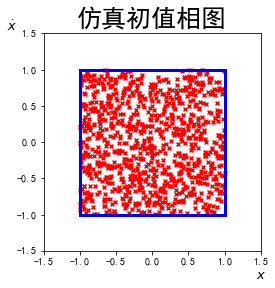

In [116]:
dt = 0.05  # 采样间隔
N_state = 2  # 状态量个数
N_sim = 200  # 仿真周期数
N_case = 1000  # 仿真次数

# 随机生成初始条件和输入
x_init_train = np.random.rand(N_state, N_case) * 2 - 1
u_snapshot_train = np.random.rand(1, N_sim * N_case) * 2 - 1

# 可使用0输入检验建模准确性
# u_snapshot_train = np.zeros((1, N_sim * N_case))

x_snapshot_train = np.zeros((N_state, N_case * (N_sim + 1)))

from matplotlib.patches import Rectangle

plt.scatter(x_init_train[0, :], x_init_train[1, :], s=15, marker="x", c="r")
rect = Rectangle((-1, -1), 2, 2, color="b", fill=False, linewidth=3)
plt.gca().add_patch(rect)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.gca().set_aspect(1)
plt.title("仿真初值相图", fontsize=25)
plt.xlabel("$x$", fontsize=13, x=1)
plt.ylabel("$\dot{x}$", fontsize=13, y=1, rotation=1)
plt.show()


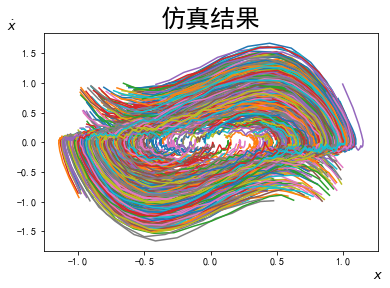

In [117]:
for i in range(N_case):
    # 导入初始条件
    x_snapshot_train[:, i * N_sim] = x_init_train[:, i]
    for j in range(N_sim):
        # 通过求解微分方程得到状态量数据，论文原代码使用龙格库塔法
        InitialCondition = x_snapshot_train[:, i * N_sim + j].tolist()
        snapshot_temp = odeint(
            VanderPol,
            InitialCondition,
            np.linspace(0, dt, 101),
            args=(u_snapshot_train[:, i * N_sim + j],),
        ).T
        x_snapshot_train[:, i * N_sim + j + 1] = snapshot_temp[:, -1]

for i in range(N_case):
    plt.plot(
        x_snapshot_train[0, i * N_sim : (i + 1) * N_sim - 1],
        x_snapshot_train[1, i * N_sim : (i + 1) * N_sim - 1],
    )

plt.title("仿真结果", fontsize=25)
plt.xlabel("$x$", fontsize=13, x=1)
plt.ylabel("$\dot{x}$", fontsize=13, y=1, rotation=1)
plt.show()


然后定义$X$、$X'$和$Y$矩阵

In [118]:
delete_list_1, delete_list_2 = [], []

for i in range(N_case):
    delete_list_1.append((i + 1) * N_sim - 1)
    delete_list_2.append(i * N_sim)

X = np.delete(x_snapshot_train, delete_list_1, axis=1)
Xprime = np.delete(x_snapshot_train, delete_list_2, axis=1)
Y = u_snapshot_train


本例中的lifting function由两部分构成：
$$
\vec{z} = \begin{bmatrix}
\vec{x} \\
g_{RBF}(\vec{x})
\end{bmatrix}
$$

In [119]:
def RBF(x, x_center, epsilon=1, k=1, TYPE="ThinPlate"):
    RADIUS = np.linalg.norm(x - x_center)

    TYPE = TYPE.lower()
    if TYPE == "thinplate":
        return 0 if RADIUS == 0 else np.power(RADIUS, 2) * np.log(RADIUS)
    elif TYPE == "gauss":
        return np.exp(-np.power(epsilon * RADIUS, 2))
    elif TYPE == "invquad":
        return 1 / (1 + np.power(epsilon * RADIUS, 2))
    elif TYPE == "invmultquad":
        return 1 / np.sqrt(1 + np.power(epsilon * RADIUS, 2))
    elif TYPE == "polyharmonic":
        return np.power(RADIUS, k) * np.log(RADIUS)


def LiftFun(x, x_center, Type="thinplate", Epsilon=1, K=1, WithOriginalState=True):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    x_rbf = np.zeros((len(x_center), x.shape[1]))

    for column in range(x_rbf.shape[1]):
        for row in range(len(x_center)):
            x_rbf[row, column] = RBF(
                x[:, column].reshape(-1, 1),
                x_center[row],
                epsilon=Epsilon,
                k=K,
                TYPE=Type,
            )

    if WithOriginalState:
        return np.concatenate((x, x_rbf), axis=0)
    else:
        return x_rbf.reshape(-1, x.shape[1])


论文Matlab源码中，RBF函数中心点取相平面上$[-1,-1]\times[-1,1]$的正方形中的随机点

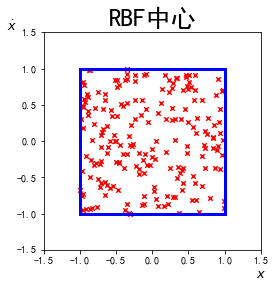

In [120]:
N_RBFcenters = 200

centers = np.random.rand(N_state, N_RBFcenters) * 2 - 1

plt.scatter(centers[0, :], centers[1, :], s=20, marker="x", c="r")
rect = Rectangle((-1, -1), 2, 2, color="b", fill=False, linewidth=3)
plt.gca().add_patch(rect)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.gca().set_aspect(1)
plt.title("RBF中心", fontsize=25)
plt.xlabel("$x$", fontsize=13, x=1)
plt.ylabel("$\dot{x}$", fontsize=13, y=1, rotation=1)
plt.show()


最后构造测量空间数据（*直接作用在矩阵上出了问题，改用涉及数据类型转换的方式，计算非常慢，需优化这一步*）

In [121]:
centers_tuple = [centers[:, i] for i in range(centers.shape[1])]
centers_tuple = tuple(centers_tuple)

Z = LiftFun(X, centers_tuple, Type="thinplate", WithOriginalState=True)
Zprime = LiftFun(Xprime, centers_tuple, Type="thinplate", WithOriginalState=True)


## 3. 基于DMDc的Koopman线性控制系统辨识

论文中的**DMDc**推导方式与第1节中略有不同。在第1节的推导中，$A$阵和$B$阵是通过如下方式得到的：

$$
\begin{bmatrix}
    A&B
\end{bmatrix}
=X' \begin{bmatrix}
    X \\ Y
    \end{bmatrix}^{\dagger}
$$

根据第1节推导，定义**DMDc**函数。

In [122]:
def DMDc_Typical(X, Xprime, Y, p=-1):
    Omega = np.concatenate((X, Y), axis=0)

    # Step 1 Apply SVD on [X;Y]
    U, Sigma, V_trans = np.linalg.svd(Omega, full_matrices=False)
    # Truncate U,Sigma,V to order p
    if p == -1:
        U_p, Sigma_p, V_p = U, np.diag(Sigma), V_trans.T
    else:
        U_p = U[:, :p]
        Sigma_p = np.diag(Sigma[:p])
        V_p = V_trans[:p, :].T

    # Step 2 Obtain G
    G = Xprime @ V_p @ np.linalg.inv(Sigma_p) @ U_p.conj().T

    # Step 3 Obtain A & B from G

    A, B = G[:, : X.shape[0]], G[:, X.shape[0] :]

    return A, B


Milan等按照如下方式辨识线性控制系统：

为方便MPC运算，假设原相空间中的数据$x$与测量空间中对应的$z$满足线性关系$\vec{x}=C\vec{z}$，则有：

$$
\left
\{
   \begin{aligned}
   Z'& = A Z + B Y \\
   X& = C Z
   \end{aligned}
\right. 
$$

这其实相当于一个状态量时程数据为$Z$，输入量时程数据为$Y$，输出量时程数据为$X$的离散线性控制系统。$A$、$B$和$C$分别是系统的系统矩阵、输入矩阵和输出矩阵。可以将其写为一个矩阵方程，并进行如下处理：

$$
\begin{aligned}
\begin{bmatrix}Z' \\ X \end{bmatrix} &=
\begin{bmatrix}
A & B \\
C & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}Z \\ Y \end{bmatrix} \\

\begin{bmatrix}Z' \\ X \end{bmatrix}
\begin{bmatrix}
   Z \\
   Y
   \end{bmatrix}^{H}
 & =\begin{bmatrix}
   A & B \\
   C & \mathbf{0}
   \end{bmatrix}
   \begin{bmatrix}Z \\ Y \end{bmatrix}
   \begin{bmatrix}Z \\ Y \end{bmatrix}^{H} \\

\Rightarrow
\begin{bmatrix}
A & B \\
C & \mathbf{0}
\end{bmatrix} & = 
\begin{bmatrix}Z' \\ X \end{bmatrix}
\begin{bmatrix}
   Z \\
   Y
\end{bmatrix}^{H} \left(
   \begin{bmatrix}Z \\ Y \end{bmatrix}
   \begin{bmatrix}Z \\ Y \end{bmatrix}^{H}
\right)^{\dagger}

\end{aligned}
$$

如此，可一次性辨识$A$、$B$和$C$。*论文中是转置，但Matlab程序中是共轭转置。*

In [123]:
def DMDc_Milan(Z, Zprime, Y, X):
    W_left, W_right = (
        np.concatenate((Zprime, X), axis=0) @ np.concatenate((Z, Y), axis=0).conj().T,
        np.concatenate((Z, Y), axis=0) @ np.concatenate((Z, Y), axis=0).conj().T,
    )

    A_B_C_0 = W_left @ np.linalg.pinv(W_right)

    A = A_B_C_0[: Zprime.shape[0], : Z.shape[0]]
    B = A_B_C_0[: Zprime.shape[0], Z.shape[0] :]
    C = A_B_C_0[Zprime.shape[0] :, : Z.shape[0]]
    # 看右下角是不是全0，直接对右下角所有元素的平方求和
    error = np.sum(np.power(A_B_C_0[Zprime.shape[0] :, Z.shape[0] :], 2))

    return A, B, C, error


def DMDc_Milan_SVD(Z, Zprime, Y, X, r=-1):
    W_left, W_right = (
        np.concatenate((Zprime, X), axis=0) @ np.concatenate((Z, Y), axis=0).conj().T,
        np.concatenate((Z, Y), axis=0) @ np.concatenate((Z, Y), axis=0).conj().T,
    )

    U, Sigma, V_trans = np.linalg.svd(W_right, full_matrices=False)

    if r == -1:
        U_r, Sigma_r, V_trans_r = U, Sigma, V_trans
        Sigma_r = np.diag(Sigma_r)
    else:
        U_r = U[:, :r]
        Sigma_r = np.diag(Sigma[:r])
        V_trans_r = V_trans[:r, :]

    A_B_C_0 = W_left @ V_trans_r.T @ np.linalg.inv(Sigma_r) @ U_r.conj().T

    A = A_B_C_0[: Zprime.shape[0], : Z.shape[0]]
    B = A_B_C_0[: Zprime.shape[0], Z.shape[0] :]
    C = A_B_C_0[Zprime.shape[0] :, : Z.shape[0]]
    # 看右下角是不是全0，直接对右下角所有元素的平方求和
    error = np.sum(np.power(A_B_C_0[Zprime.shape[0] :, Z.shape[0] :], 2))

    return A, B, C, error


检验两种方式结果右下角是否全0

In [124]:
error1, error2 = DMDc_Milan(Z, Zprime, Y, X)[3], DMDc_Milan_SVD(Z, Zprime, Y, X)[3]
print(error1, error2)


5.965337654705907e-21 2.664825189504074e-23


对比两种方式计算结果

In [125]:
print(
    np.sum(
        np.power(DMDc_Milan(Z, Zprime, Y, X)[0] - DMDc_Milan_SVD(Z, Zprime, Y, X)[0], 2)
    ),
    np.sum(
        np.power(DMDc_Milan(Z, Zprime, Y, X)[1] - DMDc_Milan_SVD(Z, Zprime, Y, X)[1], 2)
    ),
    np.sum(
        np.power(DMDc_Milan(Z, Zprime, Y, X)[2] - DMDc_Milan_SVD(Z, Zprime, Y, X)[2], 2)
    ),
)


900708233325.3599 1.7496361992106284e-06 1.6756579999250585


可见，计算结果基本一致。在很多文献中，由于$\vec{x}=C \vec{z}=C \begin{pmatrix} \vec{x} \\ g(\vec{x}) \end{pmatrix}$，直接认为$C=\begin{bmatrix} I & \mathbf{0} \end{bmatrix}$。下面检验$C$阵是否由单位阵和零矩阵拼接而成。

In [126]:
A_Typical, B_Typical, C_Typical = (
    DMDc_Typical(Z, Zprime, Y)[0],
    DMDc_Typical(Z, Zprime, Y)[1],
    X @ np.linalg.pinv(Z),
)

A_Milan, B_Milan, C_Milan = (
    DMDc_Milan(Z, Zprime, Y, X)[0],
    DMDc_Milan(Z, Zprime, Y, X)[1],
    DMDc_Milan(Z, Zprime, Y, X)[2],
)

print(C_Typical[:, : C_Typical.shape[0]], "\n", C_Milan[:, : C_Milan.shape[0]])
print(
    np.sum(np.power(C_Typical[:, C_Typical.shape[0] :], 2)),
    "\n",
    np.sum(np.power(C_Milan[:, C_Milan.shape[0] :], 2)),
)


[[1.00000000e+00 4.54747351e-12]
 [1.45519152e-11 1.00000000e+00]] 
 [[ 9.99751947e-01 -2.49749297e-04]
 [-3.10837260e-04  9.99688734e-01]]
1.8643147890694234e-07 
 0.0007507466108594041


## 4. 验证代理模型精度

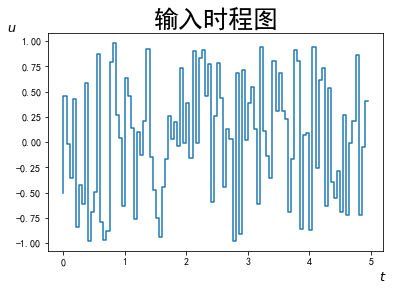

In [127]:
N_sim_test = 100

x_init_test = np.random.rand(N_state, 1) * 2 - 1
u_snapshot_test = np.random.rand(1, N_sim_test) * 2 - 1

plt.step(np.arange(0, N_sim_test * dt, dt), u_snapshot_test.flatten())
plt.title("输入时程图", fontsize=25)
plt.xlabel("$t$", fontsize=13, x=1)
plt.ylabel("$u$", fontsize=13, y=1, rotation=1)
plt.show()


In [128]:
x_snapshot_test_true = np.zeros((N_state, N_sim_test + 1))
x_snapshot_test_true[:, 0] = x_init_test.reshape(
    -1,
)
x_snapshot_test_DMDc_Typical, x_snapshot_test_DMDc_Milan = (
    np.zeros((N_state, N_sim_test + 1)),
    np.zeros((N_state, N_sim_test + 1)),
)

x_snapshot_test_DMDc_Typical[:, 0] = x_init_test.reshape(
    -1,
)
x_snapshot_test_DMDc_Milan[:, 0] = x_init_test.reshape(
    -1,
)

for j in range(N_sim_test):
    # 通过求解微分方程得到状态量数据，论文原代码使用龙格库塔法
    InitialCondition = x_snapshot_test_true[:, j].tolist()
    snapshot_temp = odeint(
        VanderPol,
        InitialCondition,
        np.linspace(0, dt, 101),
        args=(u_snapshot_test[:, j],),
    ).T
    x_snapshot_test_true[:, j + 1] = snapshot_temp[:, -1]

for j in range(N_sim_test):
    z_temp_DMD_Typical = LiftFun(
        x_snapshot_test_DMDc_Typical[:, j],
        centers_tuple,
        Type="thinplate",
    )
    z_temp_DMD_Milan = LiftFun(
        x_snapshot_test_DMDc_Milan[:, j],
        centers_tuple,
        Type="thinplate",
    )

    zprime_temp_DMD_Typical = A_Typical @ z_temp_DMD_Typical + (
        B_Typical @ u_snapshot_test[:, j]
    ).reshape(N_state + N_RBFcenters, 1)
    zprime_temp_DMD_Milan = A_Milan @ z_temp_DMD_Milan + (
        B_Milan @ u_snapshot_test[:, j]
    ).reshape(N_state + N_RBFcenters, 1)

    x_typical_temp = C_Typical @ zprime_temp_DMD_Typical
    x_snapshot_test_DMDc_Typical[:, j + 1] = x_typical_temp[:, -1]

    x_Milan_temp = C_Milan @ zprime_temp_DMD_Milan
    x_snapshot_test_DMDc_Milan[:, j + 1] = x_Milan_temp[:, -1]


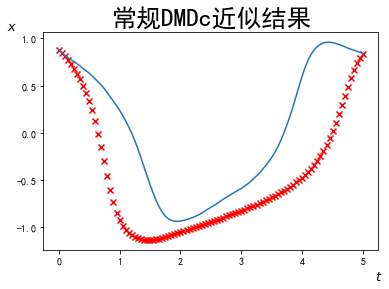

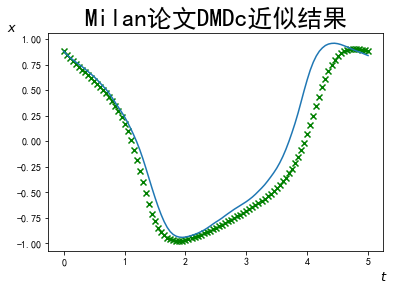

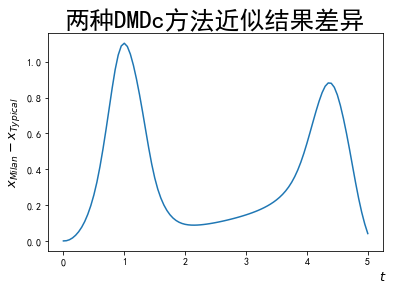

In [132]:
plt.plot(np.linspace(0, N_sim_test * dt, N_sim_test + 1), x_snapshot_test_true[0, :])
plt.scatter(
    np.linspace(0, N_sim_test * dt, N_sim_test + 1),
    x_snapshot_test_DMDc_Typical[0, :],
    marker="x",
    c="r",
)
plt.title("常规DMDc近似结果", fontsize=25)
plt.xlabel("$t$", fontsize=13, x=1)
plt.ylabel("$x$", fontsize=13, y=1, rotation=1)
plt.show()

plt.plot(np.linspace(0, N_sim_test * dt, N_sim_test + 1), x_snapshot_test_true[0, :])
plt.scatter(
    np.linspace(0, N_sim_test * dt, N_sim_test + 1),
    x_snapshot_test_DMDc_Milan[0, :],
    marker="x",
    c="g",
)
plt.title("Milan论文DMDc近似结果", fontsize=25)
plt.xlabel("$t$", fontsize=13, x=1)
plt.ylabel("$x$", fontsize=13, y=1, rotation=1)
plt.show()

plt.plot(
    np.linspace(0, N_sim_test * dt, N_sim_test + 1),
    x_snapshot_test_DMDc_Milan[0, :] - x_snapshot_test_DMDc_Typical[0, :],
)
plt.title("两种DMDc方法近似结果差异", fontsize=25)
plt.xlabel("$t$", fontsize=13, x=1)
plt.ylabel("$x_{Milan}-x_{Typical}$", fontsize=13)
plt.show()


## 5. 未来改进方向

未来有以下方面可以进行尝试：

1. 参考**启发式方法**以及**神经网络超参数优化方法**，实现RBF函数中心的优化
2. 文中仅对Van der Pol系统辨识，展示基于Koopman高维线性控制系统代理模型的MPC效果，需进一步仿真验证
3. $C$阵理论上讲可取为$\begin{bmatrix} I & \mathbf{0} \end{bmatrix}$形式，然而辨识结果不同，需进一步通过仿真，验证**测量空间是否应包含原状态量**，以及**是否应该辨识$C$阵**